<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/TSFO_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded 26 nodes.
Graph: 26 nodes, 50 edges
Centrality computed.
OTFlow computed. Example:
[(('Braga', 'Viana do Castelo'), 4.2109280306897485), (('Aveiro', 'Coimbra'), 3.5015276680675997), (('Lisboa', 'Setúbal'), 3.45952899334301), (('Setúbal', 'Lisboa'), 3.45952899334301), (('Braga', 'Porto'), 3.4548937687855124)]
TFI computed.


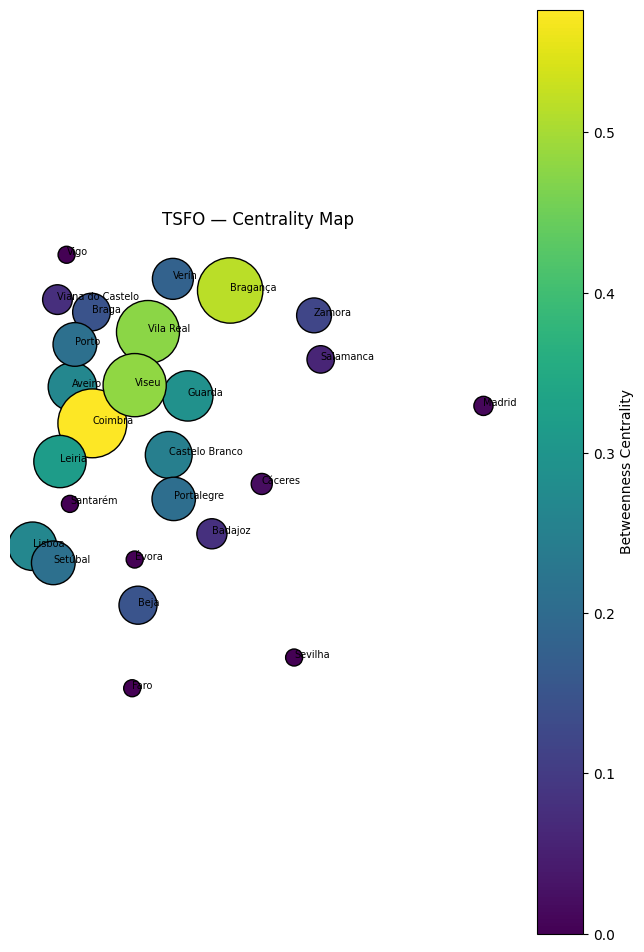

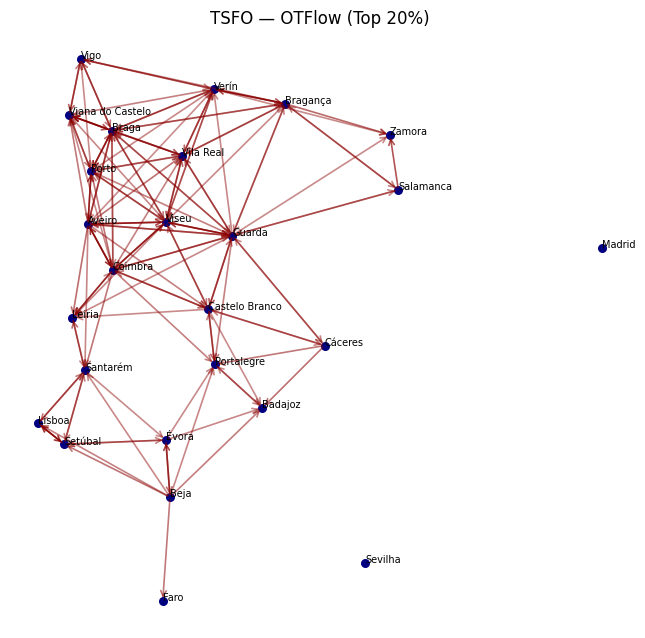

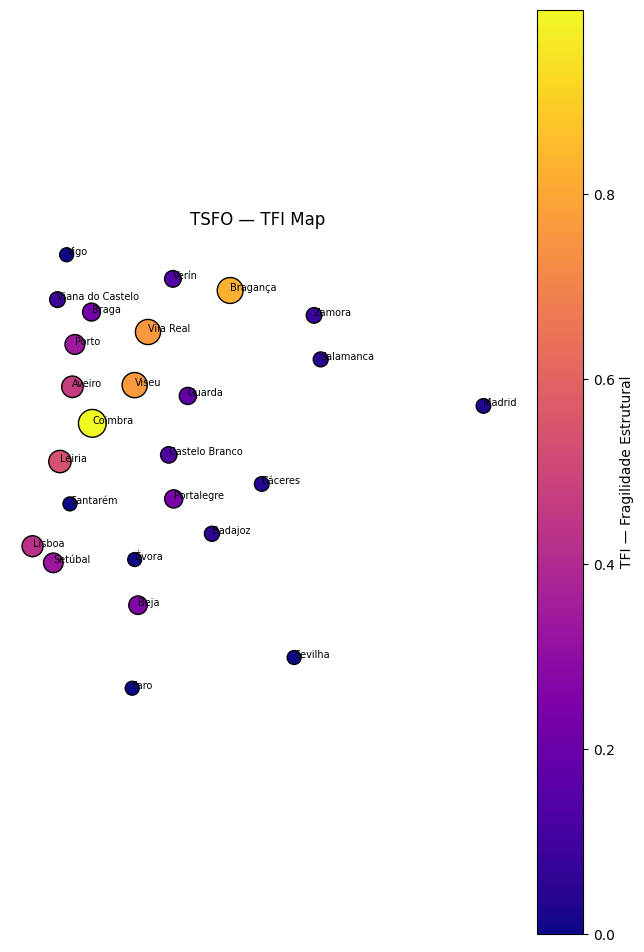


===== TSFO v7 — SUMMARY =====
Nodes: 26
Edges: 50
Strongest Hub: Coimbra
Most Fragile Node: Coimbra
Highest PageRank: Portalegre

TSFO_v7 Notebook Completed Successfully.


In [11]:
# ============================================
# TSFO v7 — Topological Social Flow Optimization
# Full Notebook — Clean & Working Version
# ============================================

import numpy as np
import pandas as pd
import math
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

plt.rcParams['figure.figsize'] = (8,12)

# ---------------------------------------------------------
# 1) NODES & COORDINATES
# ---------------------------------------------------------
coords = {
    "Aveiro": (40.64, -8.65), "Beja": (38.01, -7.86),
    "Braga": (41.54, -8.42), "Bragança": (41.80, -6.75),
    "Castelo Branco": (39.82, -7.49), "Coimbra": (40.20, -8.41),
    "Évora": (38.56, -7.90), "Faro": (37.01, -7.93),
    "Guarda": (40.53, -7.26), "Leiria": (39.74, -8.80),
    "Lisboa": (38.72, -9.13), "Portalegre": (39.29, -7.43),
    "Porto": (41.15, -8.62), "Santarém": (39.23, -8.68),
    "Setúbal": (38.52, -8.88), "Viana do Castelo": (41.69, -8.83),
    "Vila Real": (41.30, -7.74), "Viseu": (40.66, -7.90),
    "Vigo": (42.23, -8.72), "Verín": (41.94, -7.44),
    "Zamora": (41.50, -5.74), "Salamanca": (40.97, -5.66),
    "Madrid": (40.41, -3.70), "Cáceres": (39.47, -6.37),
    "Badajoz": (38.87, -6.97), "Sevilha": (37.38, -5.98)
}

nodes = list(coords.keys())

# ---------------------------------------------------------
# 2) ECONOMIC DATA (placeholder/random realistic)
# ---------------------------------------------------------
gdp = {n: np.random.randint(2000,60000) for n in nodes}
population = {n: np.random.randint(80,2500) for n in nodes}
agri = {n: np.random.randint(50,220) for n in nodes}

print("Loaded", len(nodes), "nodes.")

# ---------------------------------------------------------
# 3) DISTANCE MATRIX
# ---------------------------------------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = map(math.radians, [lat1, lat2])
    dphi = math.radians(lat2 - lat1)
    dl = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dl/2)**2
    return 2 * R * math.asin(math.sqrt(a))

dist_matrix = pd.DataFrame(index=nodes, columns=nodes)

for a in nodes:
    for b in nodes:
        lat1, lon1 = coords[a]
        lat2, lon2 = coords[b]
        dist_matrix.loc[a,b] = haversine(lat1, lon1, lat2, lon2)

# ---------------------------------------------------------
# 4) ROAD NETWORK
# ---------------------------------------------------------
roads = [
    ("Porto","Aveiro"),("Aveiro","Coimbra"),("Coimbra","Leiria"),("Leiria","Lisboa"),
    ("Lisboa","Setúbal"),("Setúbal","Beja"),("Beja","Faro"),
    ("Porto","Braga"),("Braga","Viana do Castelo"),("Viana do Castelo","Vigo"),
    ("Bragança","Vila Real"),("Vila Real","Viseu"),("Viseu","Coimbra"),
    ("Guarda","Castelo Branco"),("Castelo Branco","Portalegre"),("Portalegre","Évora"),
    ("Guarda","Bragança"),("Bragança","Verín"),("Verín","Zamora"),
    ("Zamora","Salamanca"),("Salamanca","Madrid"),
    ("Portalegre","Badajoz"),("Badajoz","Cáceres"),("Cáceres","Madrid"),
    ("Beja","Sevilha")
]

# ---------------------------------------------------------
# 5) BUILD GRAPH
# ---------------------------------------------------------
def build_graph():
    G = nx.DiGraph()
    for n in nodes:
        G.add_node(n, gdp=gdp[n], pop=population[n], agri=agri[n])
    for a,b in roads:
        d = float(dist_matrix.loc[a,b])
        cap = 1/(1+d)
        G.add_edge(a,b, distance=d, capacity=cap)
        G.add_edge(b,a, distance=d, capacity=cap)
    return G

G = build_graph()
print("Graph:", len(G.nodes()), "nodes,", len(G.edges()), "edges")

# ---------------------------------------------------------
# 6) CENTRALITY
# ---------------------------------------------------------
betw = nx.betweenness_centrality(G, weight="distance", normalized=True)
close = nx.closeness_centrality(G, distance="distance")
deg = dict(G.degree())
pr = nx.pagerank(G, weight="capacity")

print("Centrality computed.")

# ---------------------------------------------------------
# 7) POSITIONS
# ---------------------------------------------------------
node_positions = {n: (coords[n][1], coords[n][0]) for n in nodes}
xs = [node_positions[n][0] for n in nodes]
ys = [node_positions[n][1] for n in nodes]

# ---------------------------------------------------------
# 8) OTFLOW
# ---------------------------------------------------------
flows = {}
for a in nodes:
    for b in nodes:
        if a == b: continue
        d = float(dist_matrix.loc[a,b])
        flows[(a,b)] = agri[a] / (1 + d)

sorted_flows = sorted(flows.items(), key=lambda x: x[1], reverse=True)
top_flows = sorted_flows[: int(0.20*len(sorted_flows)) ]

print("OTFlow computed. Example:")
print(top_flows[:5])

# ---------------------------------------------------------
# 9) TFI — FIXED VERSION
# ---------------------------------------------------------
def compute_TFI(G):
    UG = G.to_undirected()
    base_eff = nx.global_efficiency(UG)
    TFI = {}

    for n in UG.nodes():
        G2 = UG.copy()
        G2.remove_node(n)
        new_eff = nx.global_efficiency(G2)
        TFI[n] = max(0, base_eff - new_eff)

    return TFI

TFI = compute_TFI(G)
print("TFI computed.")

# ---------------------------------------------------------
# 10) PLOTS
# ---------------------------------------------------------
plt.figure(figsize=(8,12))
plt.scatter(xs, ys,
    c=[betw[n] for n in nodes],
    cmap="viridis",
    s=[150 + 4000*betw[n] for n in nodes],
    edgecolors="black"
)
for n in nodes:
    plt.text(node_positions[n][0], node_positions[n][1], n, fontsize=7)
plt.colorbar(label="Betweenness Centrality")
plt.title("TSFO — Centrality Map")
plt.gca().set_aspect('equal')
plt.axis('off')
plt.show()

plt.figure(figsize=(8,12))
max_flow = max(f for (_,f) in top_flows)

for (a,b), f in top_flows:
    x1,y1 = node_positions[a]
    x2,y2 = node_positions[b]
    alpha = 0.3 + 0.6*(f/max_flow)

    plt.annotate("",
        xy=(x2,y2), xytext=(x1,y1),
        arrowprops=dict(arrowstyle="->", color="darkred", alpha=alpha, linewidth=1.2)
    )

plt.scatter(xs, ys, color="navy", s=30)
for n in nodes:
    plt.text(node_positions[n][0], node_positions[n][1], n, fontsize=7)

plt.title("TSFO — OTFlow (Top 20%)")
plt.gca().set_aspect('equal')
plt.axis('off')
plt.show()

vals = np.array([TFI[n] for n in nodes])
norm = (vals - vals.min()) / (vals.max() - vals.min() + 1e-8)

plt.figure(figsize=(8,12))
plt.scatter(xs, ys, c=norm, cmap="plasma",
            s=100 + 300*norm, edgecolors="black")
for n in nodes:
    plt.text(node_positions[n][0], node_positions[n][1], n, fontsize=7)

plt.colorbar(label="TFI — Fragilidade Estrutural")
plt.title("TSFO — TFI Map")
plt.gca().set_aspect('equal')
plt.axis('off')
plt.show()

# ---------------------------------------------------------
# 11) EXPORT DATAFRAMES
# ---------------------------------------------------------
df_nodes = pd.DataFrame({
    "GDP": gdp,
    "Population": population,
    "Agriculture": agri,
    "Betweenness": betw,
    "Closeness": close,
    "Degree": deg,
    "PageRank": pr,
    "TFI": TFI
})

df_nodes.to_csv("TSFO_v7_nodes.csv")
df_nodes.head()

df_flows = pd.DataFrame([
    {"Origin": a, "Destination": b, "Flow": f}
    for (a,b), f in flows.items()
])
df_flows.to_csv("TSFO_v7_flows.csv", index=False)

edge_rows = []
for a,b in G.edges():
    edge_rows.append({
        "A": a, "B": b,
        "Distance_km": G[a][b]["distance"],
        "Capacity": G[a][b]["capacity"],
    })
df_edges = pd.DataFrame(edge_rows)
df_edges.to_csv("TSFO_v7_edges.csv", index=False)

# ---------------------------------------------------------
# 12) SUMMARY
# ---------------------------------------------------------
def TSFO_summary():
    print("\n===== TSFO v7 — SUMMARY =====")
    print("Nodes:", len(G.nodes()))
    print("Edges:", len(G.edges()))
    print("Strongest Hub:", max(betw, key=betw.get))
    print("Most Fragile Node:", max(TFI, key=TFI.get))
    print("Highest PageRank:", max(pr, key=pr.get))

TSFO_summary()

# ---------------------------------------------------------
# 13) CLUSTERING
# ---------------------------------------------------------
def TSFO_cluster(k=4):
    df = df_nodes.copy()
    X = df[["GDP","Population","Agriculture","Betweenness","TFI"]]
    X_scaled = StandardScaler().fit_transform(X)
    km = KMeans(n_clusters=k, n_init=20).fit(X_scaled)
    df["Cluster"] = km.labels_
    df.to_csv("TSFO_v7_clusters.csv")
    return df

TSFO_cluster(4).head()

print("\nTSFO_v7 Notebook Completed Successfully.")
